# Topic

## In this notebook I explore shifts in ratings over the time since film release

### Import libraries

In [1]:
import pandas as pd
import numpy as np

### Load Data

In [2]:
!ls ../Week-4-Pandas/movielens

Icon?             genome-scores.csv links.csv         ratings.csv
README.txt        genome-tags.csv   movies.csv        tags.csv


In [3]:
movies = pd.read_csv('../Week-4-Pandas/movielens/movies.csv', sep=',')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [4]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
movies.head(2)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995


In [5]:
ratings = pd.read_csv('../Week-4-Pandas/movielens/ratings.csv', sep=',')
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


# Inintial data adjusting

In [6]:
rating_tags = ratings[['movieId','rating']].groupby('movieId', as_index=False).count()
rating_tags.head(), rating_tags.shape

(   movieId  rating
 0        1   49695
 1        2   22243
 2        3   12735
 3        4    2756
 4        5   12161, (26744, 2))

Interested only in frequently rated movies

In [7]:
is_frequently_rated = rating_tags['rating'] >=500
freq_rated = rating_tags[is_frequently_rated]
freq_rated.shape

(4489, 2)

Only the year of rating needed and getting time range of ratings in the data

In [8]:
ratings['parsed_time'] = pd.to_datetime(ratings['timestamp'], unit = 's')
ratings.head()

,userId,movieId,rating,timestamp,parsed_time
0,1,2,3.5,1112486027,2005-04-02 23:53:47
1,1,29,3.5,1112484676,2005-04-02 23:31:16
2,1,32,3.5,1112484819,2005-04-02 23:33:39
3,1,47,3.5,1112484727,2005-04-02 23:32:07
4,1,50,3.5,1112484580,2005-04-02 23:29:40


In [28]:
min(ratings['parsed_time']), max(ratings['parsed_time'])

(Timestamp('1995-01-09 11:46:44'), Timestamp('2015-03-31 06:40:02'))

In [9]:
ratings['year_of_rating'] = ratings['parsed_time'].map(lambda x: x.year)
ratings.head(2)

,userId,movieId,rating,timestamp,parsed_time,year_of_rating
0,1,2,3.5,1112486027,2005-04-02 23:53:47,2005
1,1,29,3.5,1112484676,2005-04-02 23:31:16,2005


In [10]:
del ratings['timestamp']
ratings.head(2)

,userId,movieId,rating,parsed_time,year_of_rating
0,1,2,3.5,2005-04-02 23:53:47,2005
1,1,29,3.5,2005-04-02 23:31:16,2005


In [11]:
del ratings['parsed_time']
ratings.shape

(20000263, 4)

In [12]:
ratings_by_years = ratings.groupby(['movieId', 'year_of_rating'], as_index=False).count()
ratings_by_years[50:60]

,movieId,year_of_rating,userId,rating
50,3,2006,621,621
51,3,2007,275,275
52,3,2008,245,245
53,3,2009,141,141
54,3,2010,110,110
55,3,2011,116,116
56,3,2012,182,182
57,3,2013,39,39
58,3,2014,31,31
59,3,2015,24,24


In [13]:
ratings_ave_by_years = ratings.groupby(['movieId', 'year_of_rating'], as_index=False).mean()
ratings_ave_by_years.head()

,movieId,year_of_rating,userId,rating
0,1,1996,69576.517645,4.132270
1,1,1997,69509.712369,3.875424
2,1,1998,68057.284012,3.885799
3,1,1999,69238.311586,3.974688
4,1,2000,70310.863602,4.142609


In [14]:
ratings_by_years['average_rating'] = ratings_ave_by_years['rating']
ratings_by_years[50:60]

,movieId,year_of_rating,userId,rating,average_rating
50,3,2006,621,621,2.758454
51,3,2007,275,275,2.990909
52,3,2008,245,245,3.112245
53,3,2009,141,141,3.102837
54,3,2010,110,110,2.986364
55,3,2011,116,116,3.051724
56,3,2012,182,182,2.799451
57,3,2013,39,39,3.064103
58,3,2014,31,31,3.048387
59,3,2015,24,24,2.854167


In [15]:
ratings_by_years = ratings_by_years.rename(index=str, columns={'rating': 'count'})
ratings_by_years.columns

Index(['movieId', 'year_of_rating', 'userId', 'count', 'average_rating'], dtype='object')

In [16]:
ratings_by_years.isnull().any()

movieId           False
year_of_rating    False
userId            False
count             False
average_rating    False
dtype: bool

In [59]:
int(movies[:1]['year'])

1995

## Defining function to get average rating for different periods of time for each film

In [21]:
def getAverageR(df):
    if sum(df['count']) == 0:
        return -1
    return sum(df['count'] * df['average_rating'])/sum(df['count'])


def getAverageRatings(row, ratings):
    ''' 
    input: 
    row - line of movies table
    ratings - dataFrames of ratings
    output:
    return list of average ratings for the film from row, where
        brand_new - average rating for the year of release and the next one
        new - average rating for the first 2-5 years after release
        old - average rating for the first 6-10 years after release
    '''
    issued = int(row['year'])
    movieId = int(row['movieId'])
    brand_new_filter = ((ratings['year_of_rating'] >= issued) 
                        & (ratings['year_of_rating'] < issued + 3))
    new_filter =       ((ratings['year_of_rating'] - issued > 2) 
                        & (ratings['year_of_rating'] - issued < 6))
    old_filter =       ((ratings['year_of_rating'] - issued > 5) 
                        & (ratings['year_of_rating'] - issued < 11))
    movie_ratings = ratings[(ratings['movieId'] == movieId)]
    
    brand_new = getAverageR(movie_ratings[brand_new_filter])
    new = getAverageR(movie_ratings[new_filter])
    old = getAverageR(movie_ratings[old_filter])
    return [brand_new, new, old]

def getRatings(row):
    return getAverageRatings(row, ratings_by_years)

In [22]:
getAverageRatings(movies[:1], ratings_by_years)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[4.0066344559025024, 4.049508740589511, 3.9167867435158503]

# Cleaning data

In [19]:
movies.isnull().any()

movieId    False
title      False
genres     False
year        True
dtype: bool

In [24]:
movies = movies.dropna()
movies.shape

(27261, 4)

In [25]:
movies = movies[movies['year'].str.isnumeric()]
movies.shape

(27255, 4)

 Only movies from 1995 till 2005 could have all needed ratings

In [26]:
relevant_movies_filter = movies['year'].apply(int).between(1995, 2005, inclusive=True)
movies[relevant_movies_filter].shape

(6634, 4)

In [27]:
movies_data = movies[relevant_movies_filter]

movies_data.shape

(6634, 4)

In [28]:
is_enough_rated = movies_data['movieId'].map(lambda x: x in freq_rated['movieId'])
movies_enough_rated = movies_data[is_enough_rated]
movies_enough_rated.shape

(1508, 4)

In [31]:
getRatings(movies_enough_rated[100:101])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.6666666666666665, 2.2, 2.6666666666666665]

In [32]:
my_ratings = movies_enough_rated.apply(lambda x: getRatings(x), axis =1, result_type='expand')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Getting statistics for research

In [33]:
my_ratings.head()

,0,1,2
0,4.006634,4.049509,3.916787
1,3.554019,3.165625,2.945473
2,3.339769,3.014898,2.868125
3,3.033424,2.708709,2.653105
4,3.224019,3.001889,2.822001


And more cleaning

In [34]:
my_filter = (my_ratings[0] > 0) & (my_ratings[1] > 0) & (my_ratings[2] > 0)
my_ratings[my_filter].shape

(1426, 3)

In [35]:
my_ratings_clean = my_ratings[my_filter]

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

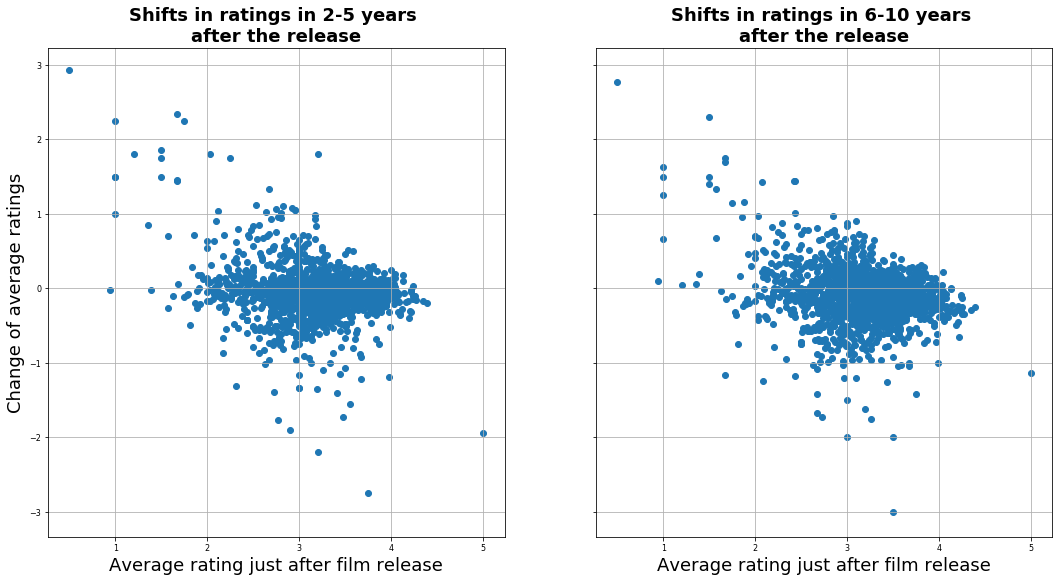

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(18,9), sharey = True)
ax0, ax1 = ax.flatten()
ax0.scatter(my_ratings_clean[0],my_ratings_clean[1] - my_ratings_clean[0])
ax0.set_title('Shifts in ratings in 2-5 years \nafter the release', fontweight='bold', size=18)
ax1.scatter(my_ratings_clean[0],my_ratings_clean[2] - my_ratings_clean[0])
ax1.set_title('Shifts in ratings in 6-10 years \nafter the release', fontweight='bold', size=18)
ax0.grid(True)
ax1.grid(True)
ax0.set_ylabel('Change of average ratings', fontsize=18)
ax0.set_xlabel('Average rating just after film release', fontsize=18)
ax1.set_xlabel('Average rating just after film release', fontsize=18)
fig.savefig('shifts_scatters.png')
plt.show

In [38]:
data = my_ratings_clean

In [40]:
corr1 = data[0].corr(data[1] - data[0])
corr2 = data[0].corr(data[2] - data[0])
corr3 = data[1].corr(data[2] - data[1])
corr1, corr2, corr3

(-0.2677447890808909, -0.27955792624715126, -0.32190225452063653)

## Another visualisation
Let's divide films into three categories based on ratings it got in the year of issue and the year after.

In [112]:
low_filter = data[0] < 2.5
high_filter = data[0] > 3.5
medium_filter = (data[0] >= 2.5) & (data[0] <= 3.5)
data[low_filter].shape, data[high_filter].shape, data[middle_filter].shape

((160, 3), (369, 3), (897, 3))

In [51]:
data.mean()

0    3.143164
1    3.085676
2    3.036718
dtype: float64

In [114]:
bar_data_dict ={'low rated films': data[low_filter].mean(),
                 'medium rated films': data[medium_filter].mean(), 
                 'high rated films': data[high_filter].mean()}
bar_data=pd.DataFrame(bar_data_dict)
bar_data.T

,0,1,2
low rated films,2.126896,2.327953,2.326546
medium rated films,3.074447,2.992614,2.940659
high rated films,3.750867,3.640453,3.578159


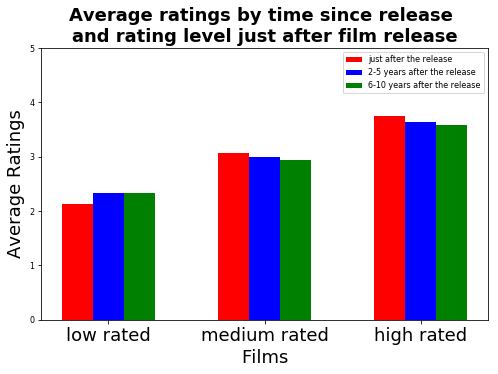

In [115]:
fig, ax = plt.subplots(figsize = (8, 5))

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.2

rects1 = ax.bar(index, bar_data.T[0], bar_width,
                 color='r',
                label='just after the release')

rects2 = ax.bar(index + bar_width, bar_data.T[1], bar_width,
                 color='b',
                label='2-5 years after the release')

rects3 = ax.bar(index + 2 * bar_width, bar_data.T[2], bar_width,
                 color='g',
                label='6-10 years after the release')

ax.set_xlabel('Films', fontsize=18)
ax.set_ylabel('Average Ratings', fontsize=18)
ax.set_title('Average ratings by time since release \nand rating level just after film release', fontweight='bold', size=18)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('low rated', 'medium rated', 'high rated'), fontsize=18)
ax.set_ylim(0, 5)
ax.legend()

fig.savefig('average_ratings.png')
plt.show()